# Tutorial - Step5 : MTMR evaluation by comparing to SOTA models

## 1. Import requirements

In [1]:
import os
import sys
import pandas as pd
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sys.path = [os.path.abspath(os.path.join(os.getcwd(), os.pardir))] + sys.path

In [3]:
from MTMR.evaluate import evaluate_metric
from MTMR.properties import qed, mcs_similarity

## 2. Specify a target property

In [4]:
PROPERTY_NAME = "qed"
SCORING_FT = qed

## 3. Set directories (for inputs and outputs)

In [5]:
input_data_dir = os.path.abspath(os.path.join(os.pardir, "DATA", PROPERTY_NAME))
input_base_dir = os.path.abspath(os.path.join(os.pardir, "DATA", "baselines"))
input_our_dir = f"outputs_2-4_{PROPERTY_NAME.upper()}_translation"

In [6]:
output_dir = f"outputs_2-5_{PROPERTY_NAME.upper()}_evaluation"
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

## 4. Set file names

In [7]:
filepath_train_rdkit = os.path.join(input_data_dir, "rdkit_train_pairs.txt")
filepath_test_rdkit = os.path.join(input_data_dir, "rdkit_test.txt")

In [8]:
df_pairs_rdkit = pd.read_csv(filepath_train_rdkit, header=None, sep=" ")
targets_rdkit = set(df_pairs_rdkit.iloc[:,1].values.tolist())

In [9]:
df_test_rdkit = pd.read_csv(filepath_test_rdkit, header=None, sep=" ")
df_test_rdkit.loc[:,1] = 0.

for i in tqdm.trange(len(df_test_rdkit)):
    smi = df_test_rdkit.iloc[i,0]
    score = SCORING_FT(smi)
    df_test_rdkit.iloc[i,1] = score

100%|██████████| 800/800 [00:00<00:00, 906.31it/s]


In [10]:
src2prop = {smi:prop for smi, prop in df_test_rdkit.values}

## 5. Load translation results generated from the test dataset

In [11]:
filepath_MTMR  = os.path.join(input_our_dir,  f"MTMR_{PROPERTY_NAME.upper()}.csv")
filepath_JTVAE = os.path.join(input_base_dir, f"JTVAE_{PROPERTY_NAME.upper()}.csv")
filepath_G2G   = os.path.join(input_base_dir, f"VJTNN_{PROPERTY_NAME.upper()}.csv")
filepath_CORE  = os.path.join(input_base_dir, f"CORE_{PROPERTY_NAME.upper()}.csv")
filepath_G2GG  = os.path.join(input_base_dir, f"VJTNN+GAN_{PROPERTY_NAME.upper()}.csv")
filepath_HIER  = os.path.join(input_base_dir, f"HierG2G_{PROPERTY_NAME.upper()}.csv")
filepath_UGMMT = os.path.join(input_base_dir, f"UGMMT_{PROPERTY_NAME.upper()}.csv")

In [12]:
df_MTMR  = pd.read_csv(filepath_MTMR,  header=None).fillna("").rename(columns={0:"SOURCE", 1:"TARGET", 2:"SIMILARITY", 3:"PROPERTY"})
df_JTVAE = pd.read_csv(filepath_JTVAE, header=None).fillna("").rename(columns={0:"SOURCE", 1:"TARGET", 2:"SIMILARITY", 3:"PROPERTY"})
df_G2G   = pd.read_csv(filepath_G2G,   header=None).fillna("").rename(columns={0:"SOURCE", 1:"TARGET", 2:"SIMILARITY", 3:"PROPERTY"})
df_CORE  = pd.read_csv(filepath_CORE,  header=None).fillna("").rename(columns={0:"SOURCE", 1:"TARGET", 2:"SIMILARITY", 3:"PROPERTY"})
df_G2GG  = pd.read_csv(filepath_G2GG,  header=None).fillna("").rename(columns={0:"SOURCE", 1:"TARGET", 2:"SIMILARITY", 3:"PROPERTY"})
df_HIER  = pd.read_csv(filepath_HIER,  header=None).fillna("").rename(columns={0:"SOURCE", 1:"TARGET", 2:"SIMILARITY", 3:"PROPERTY"})
df_UGMMT = pd.read_csv(filepath_UGMMT, header=None).fillna("").rename(columns={0:"SOURCE", 1:"TARGET", 2:"SIMILARITY", 3:"PROPERTY"})

In [13]:
frames_models = [('MTMR'       , df_MTMR   ),
                 ('JTVAE'      , df_JTVAE  ),
                 ('VJTNN'      , df_G2G    ),
                 ('VJTNN+GAN'  , df_G2GG   ),
                 ('CORE'       , df_CORE   ),
                 ('HierG2G'    , df_HIER   ),
                 ('UGMMT'      , df_UGMMT  )]

In [14]:
for name, df in frames_models:
    df.loc[:,"PROPERTY_SRC"] = 0.
    for i in tqdm.trange(len(df)):
        smi_src = df.loc[i,"SOURCE"]
        smi_tar = df.loc[i,"TARGET"]
        df.loc[i,"PROPERTY_SRC"] = src2prop.get(smi_src)

100%|██████████| 16000/16000 [00:03<00:00, 4445.45it/s]


## 6. Evaluate metrics

In [21]:
frames = []
thresholds_sim = [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7]

for i in tqdm.trange(len(frames_models)):
    name, df = frames_models[i]
    for threshold_sim in thresholds_sim:
        df_metric = evaluate_metric(df, targets_rdkit, num_decode=20,
                                    threshold_sim=threshold_sim,
                                    threshold_pro=0.9, threshold_improve=0.05).rename(columns={0:name})

        df_metric.loc["THRESHOLD_SIMILARITY",name] = threshold_sim
        frames.append(df_metric)

100%|██████████| 7/7 [06:34<00:00, 56.32s/it]


In [22]:
df_merged = pd.concat(frames, axis=1).T

In [23]:
df_merged

,VALID_RATIO,PROPERTY,IMPROVEMENT,SIMILARITY,NOVELTY,SUCCESS_PROP,SUCCESS_IMPR,DIVERSITY,THRESHOLD_SIMILARITY
MTMR,1.00000,0.866313,0.113545,0.343440,1.00000,0.42625,0.69750,0.580483,0.40
MTMR,1.00000,0.866313,0.113545,0.343440,1.00000,0.33500,0.59125,0.580483,0.45
MTMR,1.00000,0.866313,0.113545,0.343440,1.00000,0.25375,0.49000,0.580483,0.50
MTMR,1.00000,0.866313,0.113545,0.343440,1.00000,0.17500,0.36500,0.580483,0.55
MTMR,1.00000,0.866313,0.113545,0.343440,1.00000,0.10125,0.24250,0.580483,0.60
MTMR,1.00000,0.866313,0.113545,0.343440,1.00000,0.04875,0.13375,0.580483,0.65
MTMR,1.00000,0.866313,0.113545,0.343440,1.00000,0.01625,0.06500,0.580483,0.70
JTVAE,0.92625,0.733751,0.036954,0.400449,0.92500,0.05500,0.25250,0.000000,0.40
JTVAE,0.92625,0.733751,0.036954,0.400449,0.92500,0.04000,0.19375,0.000000,0.45
JTVAE,0.92625,0.733751,0.036954,0.400449,0.92500,0.02375,0.14000,0.000000,0.50


In [24]:
df_merged.to_csv(os.path.join(output_dir, "table_metrics.csv"))

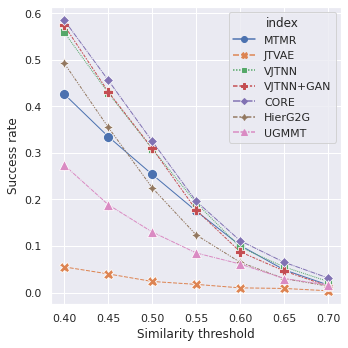

In [25]:
sns.set_theme(style='darkgrid')

fig, ax = plt.subplots(1,1,figsize=(5,5))

_ = sns.lineplot(data=df_merged.reset_index(),
                 x='THRESHOLD_SIMILARITY', y="SUCCESS_PROP", hue="index",
                 style="index", markers=True, linewidth=1, markersize=10,
                 ax=ax)

ax.set_xlabel("Similarity threshold")
ax.set_ylabel("Success rate")

plt.tight_layout()
plt.show()

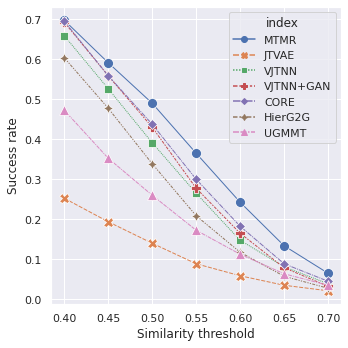

In [26]:
sns.set_theme(style='darkgrid')

fig, ax = plt.subplots(1,1,figsize=(5,5))

_ = sns.lineplot(data=df_merged.reset_index(),
                 x='THRESHOLD_SIMILARITY', y="SUCCESS_IMPR", hue="index",
                 style="index", markers=True, linewidth=1, markersize=10,
                 ax=ax)

ax.set_xlabel("Similarity threshold")
ax.set_ylabel("Success rate")

plt.tight_layout()
plt.show()